# Training the Neural Network on the Merged Dataframe

In [1]:
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers, utils, backend as K
import numpy as np
import shap
import tensorflow as tf
import pandas as pd
import tensorflow_addons as tfa
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split



2023-03-22 10:37:48.268661: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preparing the MENA Dataframe 

In [17]:
df_MENA_clean = pd.read_csv("merged_dfs_MENA_noNA.csv")

#removing non numerical columns:
df_MENA_clean = df_MENA_clean.drop(["year","month","date","Unnamed: 0.1","Unnamed: 0.2","Unnamed: 0_x","code","country_x", "geo_x", "country_code","Unnamed: 0_y","Country","Time","geo_y","economy","Unnamed: 0","iso3","country_y"], axis=1)

df_world_clean = pd.read_csv("merged_dfs_world_noNA.csv")
#removing non numerical columns:
df_world_clean = df_world_clean.drop(["geo","year","date","Unnamed: 0.1","Unnamed: 0.2","Unnamed: 0_x", "country_code","Unnamed: 0_y","Country","Time","economy","Unnamed: 0","iso3","country", "SH.MED.NUMW.P3"], axis=1)


Separating feature and target variables

In [29]:
features_MENA = df_MENA_clean.iloc[:,0:55].reset_index()
target_MENA = df_MENA_clean["unrest_index"].reset_index()
features_MENA = features_MENA.drop("index", axis = 1)

features_world = df_world_clean.iloc[:,0:55].reset_index()
target_world = df_world_clean["unrest_index"].reset_index()
features_world = features_world.drop("index", axis = 1)


In [30]:
tf.convert_to_tensor(features_MENA)
tf.convert_to_tensor(features_world)
normaliser = tf.keras.layers.Normalization(axis=-1) 
normaliser.adapt(features_MENA)
normaliser.adapt(features_world)

## Setting up the Neural Network

In [53]:

def R_squared(y, y_pred):
  residual = tf.reduce_sum(tf.square(tf.subtract(y, y_pred)))
  total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
  r2 = tf.subtract(1.0, tf.divide(residual, total))
  return r2

def get_model(n_features):
    '''
    n_features -- number of feature variables
    
    returns a model 
    '''
    model = models.Sequential(name="NN", layers = [
    normaliser,
    #hidden layer 1
    layers.Dense(name="h1", input_dim=n_features, units=50, activation='relu'),
    #preventing overfitting by regularising
    layers.Dropout(name="drop1", rate=0.2),
    
    # hidden layer 2
    layers.Dense(name="h2", units=20,activation='relu'),
    layers.Dropout(name="drop2", rate=0.2),

    # hidden layer 3
    layers.Dense(name="h3", units=10,activation='relu'),
    layers.Dropout(name="drop3", rate=0.2),
    
    # output layer
    layers.Dense(name="output", units=1, activation='relu')
    ])

    #set loss depending on regression or classification
    model.compile(optimizer='RMSprop', loss="mse", metrics=["mse",R_squared])
    return model

In [32]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

def plot_metric(history, metric):
    plt.plot(history.history[metric], label=metric)
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)

def plot_predictions(model, y_test, x_test):
    test_predictions = model.predict(x_test).flatten()

    y_test = y_test["unrest_index"]

    a = plt.axes(aspect='equal')
    plt.scatter(y_test, test_predictions)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')



## Training on MENA

In [89]:
model_MENA = get_model(55)

model_MENA.summary() 


Model: "NN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 55)               111       
 ion)                                                            
                                                                 
 h1 (Dense)                  (None, 50)                2800      
                                                                 
 drop1 (Dropout)             (None, 50)                0         
                                                                 
 h2 (Dense)                  (None, 20)                1020      
                                                                 
 drop2 (Dropout)             (None, 20)                0         
                                                                 
 h3 (Dense)                  (None, 10)                210       
                                                                

In [90]:

#obtain a train and test split
x_train_m, x_test_m, y_train_m, y_test_m = train_test_split(features_MENA, target_MENA, test_size = 0.2, random_state = 4) 

y_train_m = y_train_m.drop("index", axis = 1)
y_test_m = y_test_m.drop("index", axis = 1)


#train the model with the training data over 100 epochs
training_m = model_MENA.fit(x_train_m, y_train_m, epochs=200, batch_size=64)

model_MENA.evaluate(x_test_m, y_test_m)    



Epoch 1/200
12/12 [==============================] - 1s 2ms/step - loss: 0.8599 - mse: 0.8599 - R_squared: -0.2325
Epoch 2/200
12/12 [==============================] - 0s 2ms/step - loss: 0.6674 - mse: 0.6674 - R_squared: 0.0367
Epoch 3/200
12/12 [==============================] - 0s 2ms/step - loss: 0.8008 - mse: 0.8008 - R_squared: -0.2819
Epoch 4/200
12/12 [==============================] - 0s 2ms/step - loss: 0.7264 - mse: 0.7264 - R_squared: -0.0580
Epoch 5/200
12/12 [==============================] - 0s 2ms/step - loss: 0.6484 - mse: 0.6484 - R_squared: 0.0941
Epoch 6/200
12/12 [==============================] - 0s 2ms/step - loss: 0.6417 - mse: 0.6417 - R_squared: 0.0972
Epoch 7/200
12/12 [==============================] - 0s 2ms/step - loss: 0.6086 - mse: 0.6086 - R_squared: 0.0031
Epoch 8/200
12/12 [==============================] - 0s 2ms/step - loss: 0.5820 - mse: 0.5820 - R_squared: 0.1467
Epoch 9/200
12/12 [==============================] - 0s 2ms/step - loss: 0.5346 - mse

[0.9283390641212463, 0.9283390641212463, 0.25927165150642395]

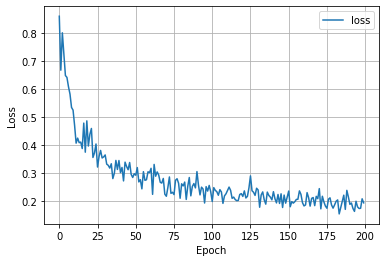

In [91]:
plot_loss(training_m)

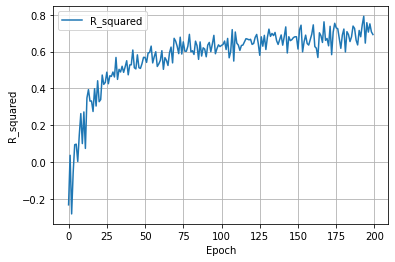

In [92]:
plot_metric(training_m, "R_squared")

6/6 [==============================] - 0s 1ms/step


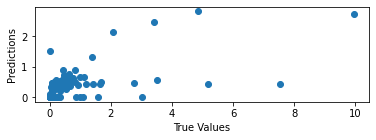

In [94]:
plot_predictions(model_MENA, y_test_m, x_test_m)

## Training the Neural Network on the World Dataframe

In [84]:
model_world = get_model(55)

model_world.summary() 

Model: "NN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 55)               111       
 ion)                                                            
                                                                 
 h1 (Dense)                  (None, 50)                2800      
                                                                 
 drop1 (Dropout)             (None, 50)                0         
                                                                 
 h2 (Dense)                  (None, 20)                1020      
                                                                 
 drop2 (Dropout)             (None, 20)                0         
                                                                 
 h3 (Dense)                  (None, 10)                210       
                                                                

In [85]:
#obtain a train and test split
x_train_w, x_test_w, y_train_w, y_test_w = train_test_split(features_world, target_world, test_size = 0.2, random_state = 4) 

y_train_w = y_train_w.drop("index", axis = 1)
y_test_w = y_test_w.drop("index", axis = 1)


#train the model with the training data over 100 epochs
training_w = model_world.fit(x_train_w, y_train_w, epochs=200, batch_size=64)

model_world.evaluate(x_test_w, y_test_w)    


Epoch 1/200
10/10 [==============================] - 1s 2ms/step - loss: 1.4845 - mse: 1.4845 - R_squared: -0.6722
Epoch 2/200
10/10 [==============================] - 0s 2ms/step - loss: 1.3517 - mse: 1.3517 - R_squared: -0.7410
Epoch 3/200
10/10 [==============================] - 0s 2ms/step - loss: 1.2879 - mse: 1.2879 - R_squared: -0.1596
Epoch 4/200
10/10 [==============================] - 1s 60ms/step - loss: 1.3054 - mse: 1.3054 - R_squared: -0.0823
Epoch 5/200
10/10 [==============================] - 0s 2ms/step - loss: 1.2463 - mse: 1.2463 - R_squared: -0.0711
Epoch 6/200
10/10 [==============================] - 0s 3ms/step - loss: 1.2289 - mse: 1.2289 - R_squared: -0.0388
Epoch 7/200
10/10 [==============================] - 0s 2ms/step - loss: 1.0075 - mse: 1.0075 - R_squared: 0.1102
Epoch 8/200
10/10 [==============================] - 0s 3ms/step - loss: 1.0979 - mse: 1.0979 - R_squared: 0.0289
Epoch 9/200
10/10 [==============================] - 0s 2ms/step - loss: 0.8598 -

[0.09710731357336044, 0.09710731357336044, 0.2602977752685547]

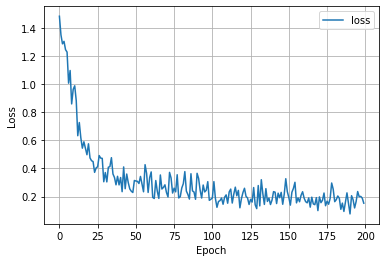

In [86]:
plot_loss(training_w)

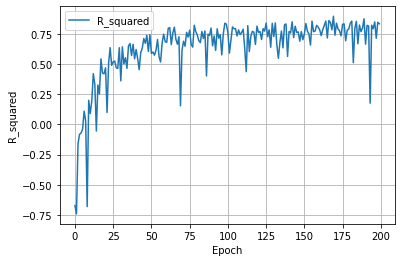

In [87]:
plot_metric(training_w, "R_squared")

5/5 [==============================] - 0s 2ms/step


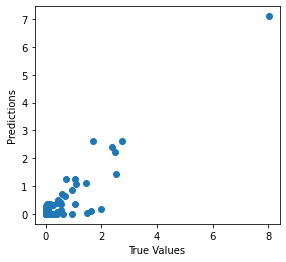

In [88]:
plot_predictions(model_world, y_test_w, x_test_w)